<a href="https://colab.research.google.com/github/BlackCurrantDS/DBSE_Project/blob/main/clustering_apriori_dbscan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading Feature vector

In [9]:
def string_2_itemset(key):
    if key == '':
        return []
    else: 
        return key.split(',')

def itemset_2_string(itemset):
    return ",".join(itemset)

In [10]:


class AssociationRule:
    def __init__(self, left, right):
        self.left_items = left
        self.right_items = right
        self.scores = []
        
    def length(self):
        return len(self.left_items) + len(self.right_items)
     
    def score(self, index):
        return self.scores[index]
    
    def lhs_string(self):
        return itemset_2_string(self.left_items)
        
    def rhs_string(self):
        return itemset_2_string(self.right_items)
    
    def serialize(self):
        left_key = self.lhs_string()
        right_key = self.rhs_string()
        return left_key + ">" + right_key
    
    @staticmethod        
    def string_2_rule(s):
        subStrings = s.split(">")
        left = string_2_itemset(subStrings[0].strip())
        right = string_2_itemset(subStrings[1].strip())
        #print("AssociationRule(left, right",AssociationRule(left, right))
        return AssociationRule(left, right)

    def append_score(self, score):
        self.scores.append(score)
        
    def get_itemset(self):
        itemset = []
        itemset.extend(self.left_items)
        itemset.extend(self.right_items)
        itemset.sort()
        return itemset
        
        
    def rule_itemset_2_string(self):
        itemset = self.get_itemset()
        return itemset_2_string(itemset)
    
    def compute_basic_probs(self,frequent_itemsets, nTransactions):  
        
        left = frequent_itemsets[self.lhs_string()]
        right = frequent_itemsets[self.rhs_string()]
        
        both = frequent_itemsets[self.rule_itemset_2_string()]
        
        vector = {}
        
        ''' 1. P(A)'''
        p_A = left/nTransactions
        vector['A'] = p_A
        
        ''' 2. P(B)'''
        p_B = right/nTransactions
        vector['B'] = p_B
        
        ''' 3. P(~A)'''
        p_not_A = 1 - p_A
        vector['~A'] = p_not_A
        
        ''' 4. P(~B)'''
        p_not_B = 1 - p_B
        vector['~B'] = p_not_B
        
        ''' 5. P(AB) '''
        p_A_and_B = both/nTransactions
        vector['AB'] = p_A_and_B
        
        ''' 6. P(~AB)'''
        p_not_A_and_B = (right - both)/nTransactions
        vector['~AB'] = p_not_A_and_B
        
        ''' 7. P(A~B)'''
        p_A_and_not_B = (left - both)/nTransactions
        vector['A~B'] = p_A_and_not_B
        
        ''' 8. P(~A~B)'''
        p_not_A_and_not_B = 1 - (left + right - both)/nTransactions
        vector['~A~B'] = p_not_A_and_not_B 
        
        '''
        9. P(A|B)
        '''
        p_A_if_B = p_A_and_B / p_B
        vector['A|B'] = p_A_if_B
        
        '''
        10. P(~A|~B)
        '''
        p_not_A_if_not_B = p_not_A_and_not_B / p_not_B
        vector['~A|~B'] = p_not_A_if_not_B
        
        '''
        11. P(A|~B)
        '''
        p_A_if_not_B = p_A_and_not_B/p_not_B
        vector['A|~B'] = p_A_if_not_B
        
        '''
        12. p(~A|B)
        '''
        p_not_A_if_B = p_not_A_and_B / p_B
        vector['~A|B'] = p_not_A_if_B
        
        '''
        13. P(B|A)
        '''
        p_B_if_A = p_A_and_B / p_A
        vector['B|A'] = p_B_if_A
        
        '''
        14. P(~B|~A)
        '''
        p_not_B_if_not_A = p_not_A_and_not_B / p_not_A
        vector['~B|~A'] = p_not_B_if_not_A
        
        '''
        15. P(B|~A)
        '''
        p_B_if_not_A = p_not_A_and_B/p_not_A
        vector['B|~A'] = p_B_if_not_A
        
        '''
        16. p(~B|A)
        '''
        p_not_B_if_A = p_A_and_not_B / p_A
        vector['~B|A'] = p_not_B_if_A
        
        return vector
    
    def is_redundant_(self, bits, k, itemset, freq_itemset_dict): 
        '''
        Run out of items --> create rule and check format criterion
        '''
        if k >= len(itemset):
            items_1 = []
            items_2 = []
            for index in range(len(bits)):
                if bits[index] == True:
                    items_1.append(itemset[index])
                else:
                    items_2.append(itemset[index])
            for item in items_2:
                rule = AssociationRule(items_1, [item])
                confidence = freq_itemset_dict.getConfidence(rule)
                if confidence == 1: return True
            return False 
      
        value_domain = [True, False]
        for value in value_domain:
            bits[k] = value
            checker = self.is_redundant_(bits, k+1, itemset, freq_itemset_dict)
            if checker == True: return True
            bits[k] = True    
        return False
    
    '''
    Expand an item-set with equivalent items.
    '''
    def is_redundant(self, freq_itemset_dict):
        bits = [True for _ in self.left_items]
        checker = self.is_redundant_(bits, 0, self.left_items, freq_itemset_dict)
        if checker == True: return True
        
        bits =  [True for _ in self.right_items]
        return self.is_redundant_(bits, 0, self.right_items, freq_itemset_dict)
    
    '''
    Check if an item-set is satisfied condition of the rule. 
    '''
    def satisfy_rule(self, itemset, is_lhs = True):
        condition = self.left_items
        if is_lhs == False: condition = self.right_items
        if len(condition) > len(itemset) or len(itemset) == 0:
            return False
        for item in condition:
            if item not in itemset:
                return False
        return True
    

In [11]:
def string_2_rule(s):
        subStrings = s.split(">")
        left = string_2_itemset(subStrings[0].strip())
        right = string_2_itemset(subStrings[1].strip())
        return AssociationRule(left, right)

In [16]:
 import json
 import numpy as np
 def load_feature_vectors():
        data = []
        lengths = []
        
        with open("/content/miner.tmp.non_redundant_rules", 'r') as feature_reader:
            print('Loading number of LHS and RHS features...')
            lhs_count = int(feature_reader.readline())
            rhs_count = int(feature_reader.readline())
            print('Loading feature vectors... ')
            for line in feature_reader:
                rule_text, f_vector = json.loads(line.strip())
                rule = string_2_rule(rule_text.strip())
                lengths.append(rule.length())
                #print(rule) this rule as an object of the assocition rule class
                data.append(f_vector)
                
                
        return np.array(data), lengths, lhs_count, rhs_count

In [ ]:
X_train, lengths, lhs_feature_count, rhs_feature_count = load_feature_vectors()

In [18]:
X_train

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        , -1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        , -1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        , -1.        ],
       ...,
       [ 0.        ,  0.13880009,  0.        , ..., -0.37893465,
         1.        , -1.        ],
       [ 0.        ,  0.13880009,  0.16377452, ..., -1.        ,
         1.        , -1.        ],
       [ 0.33925584,  1.        , -0.48587977, ..., -1.        ,
         1.        , -1.        ]])

In [19]:
lengths

[2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,


In [21]:
lhs_feature_count,rhs_feature_count

(42, 2)

Loading Association Rules

In [41]:
def load_association_rules():
        association_rules_list = []
        with open("/content/miner.tmp.non_redundant_rules", 'r') as rules_reader:
            rules_reader.readline()
            rules_reader.readline()
            
            for line in rules_reader:
                rule_text, _ = json.loads(line.strip())
                association_rules_list.append(AssociationRule.string_2_rule(rule_text.strip()))
        print(association_rules_list)
        return association_rules_list

In [42]:
association_rules_list = load_association_rules()

[<__main__.AssociationRule object at 0x7f0c38b44d30>, <__main__.AssociationRule object at 0x7f0c38b44a90>, <__main__.AssociationRule object at 0x7f0c3a4dc240>, <__main__.AssociationRule object at 0x7f0c3a4dc470>, <__main__.AssociationRule object at 0x7f0c3a4dcc88>, <__main__.AssociationRule object at 0x7f0c3a4dc908>, <__main__.AssociationRule object at 0x7f0c3a4dc780>, <__main__.AssociationRule object at 0x7f0c3a4dc550>, <__main__.AssociationRule object at 0x7f0c3a4dc7f0>, <__main__.AssociationRule object at 0x7f0c3a4dce48>, <__main__.AssociationRule object at 0x7f0c3a4dc860>, <__main__.AssociationRule object at 0x7f0c3a4dc668>, <__main__.AssociationRule object at 0x7f0c3a4dc9b0>, <__main__.AssociationRule object at 0x7f0c3a4dcdd8>, <__main__.AssociationRule object at 0x7f0c3a4dca20>, <__main__.AssociationRule object at 0x7f0c3a4dcc18>, <__main__.AssociationRule object at 0x7f0c3a4dcba8>, <__main__.AssociationRule object at 0x7f0c3a4dcda0>, <__main__.AssociationRule object at 0x7f0c3a4

In [ ]:
association_rules_list

Loading frequent itemsetes

In [38]:
class ItemsetDictionary(object):
    

    def __init__(self, ntransactions = 0):
        self.itemsets = {}
        self.ntransactions = ntransactions
            
    def size(self):
        return len(self.itemsets)
    
    def exists(self, itemset_key):
        return itemset_key in self.itemsets
    
    def add_itemset(self, itemset_key, amount):
        self.itemsets[itemset_key] = amount
        
    def clear(self):
        self.itemsets.clear()
    
    def convert_2_indexes(self):
        k = 0
        dict_items_indexes = {}
        for item_name, _ in self.itemsets.items():
            dict_items_indexes[item_name] = k
            k += 1
        return dict_items_indexes
            
    def get_names(self):
        return self.itemsets.keys()
        
    def get_frequency(self, itemset_key):
        if self.exists(itemset_key):
            return self.itemsets[itemset_key]
        return 0
        
    def getConfidence(self, rule):
        left = self.get_frequency(rule.lhs_string())
        both = self.get_frequency(rule.rule_itemset_2_string())
        if left == 0: return 0
        return both/left
    
    def get_frequency_combo(self, rule):
        left = self.get_frequency(rule.lhs_string())
        right =self.get_frequency(rule.rhs_string())
        both = self.get_frequency(rule.rule_itemset_2_string())
        
        return left, right, both
    
    def get_support(self, itemset_key):     
        return self.get_frequency(itemset_key)/self.ntransactions
       
    def split(self, nchunks):
        itemsets_names = self.itemsets.keys()
        nitemsets = len(itemsets_names)
        
        print ('Number of frequent item-sets: ' + str(nitemsets))
        itemset_chunks = [[] for _ in range(nchunks)]
        size_of_chunk = (int)(nitemsets/nchunks) + 1
                    
        index = 0
        counter = 0
        
        for itemset_key in itemsets_names:
            if counter < size_of_chunk:
                itemset_chunks[index].append(string_2_itemset(itemset_key))
                counter += 1
            elif counter == size_of_chunk:
                index += 1
                itemset_chunks[index].append(string_2_itemset(itemset_key))
                counter = 1  
                  
        return itemset_chunks
    
    def save_2_file(self, file_name, write_mode = 'a', write_support = False):
        with open(file_name, write_mode) as text_file:
            for key, value in self.itemsets.items():
                t = value
                if write_support == True:
                    t = value/self.ntransactions
                text_file.write(key + ':' + str(t))
                text_file.write('\n')
            
    def load_from_file(self,file_name):
        self.itemsets.clear()
        
        with open(file_name, "r") as text_file:
            self.ntransactions = int(text_file.readline())
            for line in text_file:
                print (line)
                subStrings = line.split(':')
                itemset_key = subStrings[0].strip()
                frequency = int(subStrings[1].strip())
                
                self.itemsets[itemset_key] = frequency
                
    def _complement_condition(self, r1, r2):
        merged_itemset = merge_itemsets(r1.left_items, 
                                        r2.left_items)
        
        s = self.get_frequency(itemset_2_string(merged_itemset))
        sl = self.get_frequency(r1.lhs_string())
        sr = self.get_frequency(r2.lhs_string())
    
        #if s > 0: return True
        return max(s/sl, s/sr)
     
        
    '''
    Check if two rules are contrary each other based on the matching function
    r1, r2: dictionaries includes {'r': rule, 'f': feature vector}
    contrast_params: contains thresholds, and size of LHS, RHS features 
    '''
    def is_contrast(self, r1, r2, contrast_params):
        
        n = contrast_params.n_lhs_features
        a = cosine_similarity(np.reshape(r1['f'][n:], (1, -1)),
                              np.reshape(r2['f'][n:], (1, -1)))[0,0]
        if a > contrast_params.delta2: return (False, 0, 0)
        
        b = cosine_similarity(np.reshape(r1['f'][:n], (1, -1)), 
                              np.reshape(r2['f'][:n], (1, -1)))[0,0]
        if b <= contrast_params.delta1: return (False, 0, 0)
        
        t = self._complement_condition(r1['r'], r2['r'])
        if t > contrast_params.share_threshold:
            return (True, b, t)
        return (False, 0, 0)
    
    
    def is_inner_contrast(self, group, contrast_params):
        #print('check inner')
        both_condition = self.find_pottential_contrast_locs(group, group, contrast_params)
        if both_condition is None: return False 
        
        for i in range(len(both_condition[0])):
            x = both_condition[0][i]
            y = both_condition[1][i]
            if x >= y: continue
            t = self._complement_condition(group['r'][x], group['r'][y])
            if t > contrast_params.share_threshold: return True 
            
        return False

        
        
    def find_pottential_contrast_locs(self, group1, group2, contrast_params):
        rhs_sim = cosine_similarity(group1['rhs'], group2['rhs']) 
        rhs_condition = (rhs_sim > contrast_params.delta2).astype(int) 
        if np.all(rhs_condition > 0) == True: return None 
    
        
        lhs_sim = cosine_similarity(group1['lhs'], group2['lhs'])
        lhs_condition = (lhs_sim <= contrast_params.delta1).astype(int)
        if np.all(lhs_condition > 0) == True: return None 
        
        locs = np.where(lhs_condition + rhs_condition <= 0)
        return locs 
        
    def is_outer_contrast(self, group1, group2, contrast_params):
        #print('check outer')
        both_condition = self.find_pottential_contrast_locs(group1, group2, contrast_params)
        if both_condition is None: return False 
        
        for i in range(len(both_condition[0])):
            x = both_condition[0][i]
            y = both_condition[1][i]
            t = self._complement_condition(group1['r'][x], group2['r'][y])
            if t > contrast_params.share_threshold: return True 
            
        return False
    

In [39]:
def load_frequent_itemsets_as_dict():
        freq_itemset_dict = ItemsetDictionary(0)
        freq_itemset_dict.load_from_file("/content/miner.tmp.itemsets")
        return freq_itemset_dict

In [40]:
freq_itemset_dict = load_frequent_itemsets_as_dict()

Streaming output truncated to the last 5000 lines.
a3@10-14,a4@0-2,a5@no,a6@2,a8@left_low,a9@no:4

a3@10-14,a4@0-2,a5@no,a6@2,a8@left_low,class@no:5

a3@10-14,a4@0-2,a5@no,a6@2,a8@left_up,class@no:3

a3@10-14,a4@0-2,a5@no,a6@2,a9@no,class@no:8

a3@10-14,a4@0-2,a5@no,a7@left,a8@left_low,a9@no:6

a3@10-14,a4@0-2,a5@no,a7@left,a8@left_low,class@no:7

a3@10-14,a4@0-2,a5@no,a7@left,a8@left_up,a9@no:3

a3@10-14,a4@0-2,a5@no,a7@left,a8@left_up,class@no:3

a3@10-14,a4@0-2,a5@no,a7@left,a9@no,class@no:12

a3@10-14,a4@0-2,a5@no,a7@right,a8@left_low,a9@no:3

a3@10-14,a4@0-2,a5@no,a7@right,a8@left_low,class@no:3

a3@10-14,a4@0-2,a5@no,a7@right,a8@left_up,a9@no:5

a3@10-14,a4@0-2,a5@no,a7@right,a8@left_up,class@no:6

a3@10-14,a4@0-2,a5@no,a7@right,a9@no,class@no:9

a3@10-14,a4@0-2,a5@no,a8@left_low,a9@no,class@no:9

a3@10-14,a4@0-2,a5@no,a8@left_up,a9@no,class@no:8

a3@10-14,a4@0-2,a6@1,a7@left,a8@left_low,a9@no:3

a3@10-14,a4@0-2,a6@1,a7@left,a8@left_low,class@no:3

a3@10-14,a4@0-2,a6@1,a7@left,a8

ContrastParams

In [46]:
delta1, delta2, substantial_threshold = 0.0, -0.9, 0.0,

In [44]:
class ContrastParams(object):
    '''
    classdocs
    '''

    def __init__(self, delta1, delta2, share_threshold, n_lhs_features, n_rhs_features):
        '''
        Constructor
        '''
        self.delta1 = delta1 
        self.delta2 = delta2 
    
        self.share_threshold = share_threshold
        self.n_lhs_features = n_lhs_features
        self.n_rhs_features = n_rhs_features

In [47]:
contrast_params = ContrastParams(delta1, delta2,
                                      substantial_threshold, 
                                      lhs_feature_count, 
                                      rhs_feature_count)

In [48]:
contrast_params

In [49]:
my_minpts,my_eps = 3, 0.1

In [50]:
class dbscanParams(object):
    
    def __init__(self, minpts, eps):
        self.min_pts = minpts
        self.eps = eps

In [51]:
dbscan_params = dbscanParams(my_minpts, my_eps)

In [52]:
epsilon =5e-3

Clustering Enginer

In [89]:
class UnexpectednessExtractor(object):
    
    def __init__(self, X_train, freq_itemset_dict, rule_list, contrast_params, epsilon = 5e-5, eps_step = 0.1, reduced_rate = None):
        self.rule_list = rule_list
        self.freq_itemset_dict = freq_itemset_dict
        
        self.original_features = X_train
        self.sample_features = X_train
        
        self.contrast_params = contrast_params
        self.epsilon = epsilon
        self.eps_step = eps_step

        if reduced_rate is not None:
            ncomponents = int(X_train.shape[1] * reduced_rate) 
            pca = IncrementalPCA(n_components = ncomponents)
            self.sample_features = pca.fit_transform(X_train)
    def data_size(self):
        return len(self.rule_list)

In [90]:
clustering_engine = UnexpectednessExtractor(X_train, 
                                         freq_itemset_dict, 
                                         association_rules_list, 
                                         contrast_params,
                                         epsilon=epsilon,
                                         reduced_rate=None)
                                         #reduced_rate=0.5)

Clustering labels

In [100]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

In [82]:
eps_step = 0.1

In [76]:
rule_list = association_rules_list

In [77]:
def data_size():
        return len(rule_list)

In [102]:
class MyRulesClustering(object):
    
    def __init__(self, dbscan_params, clustering_engine, nThreads, allowed_conflict_size = 0):
        self.dbscan_params = dbscan_params
        self.best_eps = self.dbscan_params.eps
        
        self.nthreads = nThreads
        
        self.engine = clustering_engine
        self.allowed_conflict_size = allowed_conflict_size
        
        self.Y = None
        self.visisted = None



    def intialize(self):
        m = self.engine.data_size()
        self.Y = [-1 for _ in range(m)]
        self.visisted = [False for _ in range(m)]

    def region_query(self, p):
        temp = self.engine.sample_features[p,:]
        temp = np.reshape(temp, (1, -1))
       
        distance = euclidean_distances(temp, self.engine.sample_features)
        neighbors = np.where(distance <= self.best_eps)
        return neighbors[1].tolist()


    def run(self, eps_step):
        m = self.engine.data_size()
        print("this is m",m)
            
        self.best_eps = self.dbscan_params.eps
        while(self.best_eps  > 0):
            print('running for ' + str(self.best_eps))
            self.intialize()
            C = -1
            flag = True
            for p in range(m):
                if p % 100 == 0: print (p)
                if self.visisted[p] == True: continue
                
                self.visisted[p] = True
                neighbors = self.region_query(p)
                if len(neighbors) >= self.dbscan_params.min_pts:
                    C += 1
                    self.expand_cluster(p, C, neighbors)
                    if self.check_contrast(C) == True:
                        flag = False
                        break
                        
            if flag == True:
                print('Found a good eps: ' + str(self.best_eps)) 
                break
            
            self.best_eps -= eps_step

In [103]:
def run_dbscan(dbscan_params, nthreads):
        print ('Doing clustering ....')
        print('epsilon ' + str(epsilon))
        noconflict_db = MyRulesClustering(dbscan_params,
                                          clustering_engine,
                                          nthreads,
                                          epsilon * data_size())
        
        print(noconflict_db)
        
        noconflict_db.run(eps_step)
        
        Y = noconflict_db.Y.copy()
        
        n_clusters = len(set(Y))- (1 if -1 in Y else 0)
        n_noises = Y.count(-1)
        
       
        print('Number of clusters' + str(n_clusters))
        print('Number of noises' + str(n_noises))
    
        print("Y" , Y)
        print("Type of Y is ",type(Y))
        return Y

In [104]:
cluster_labels = run_dbscan(dbscan_params, nthreads = 4)

Doing clustering ....
epsilon 0.005
this is m 1687
running for 0.1
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
Found a good eps: 0.1
Number of clusters0
Number of noises1687
Y [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

Testing with sklearn

In [108]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS, cluster_optics_dbscan

In [121]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(labels)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

[-1 -1 -1 ... -1 -1 -1]
Estimated number of clusters: 0
Estimated number of noise points: 1687


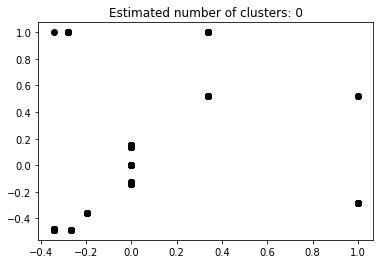

In [122]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_train[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_train[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [112]:
clust = OPTICS(min_samples=10, xi=.05, min_cluster_size=.05)

# Run the fit
clust.fit(X_train)

core_samples_mask = np.zeros_like(clust.labels_, dtype=bool)

labels = clust.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(labels)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

[0 0 0 ... 0 0 0]
Estimated number of clusters: 2
Estimated number of noise points: 0


In [113]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Automatic Clustering\nOPTICS')

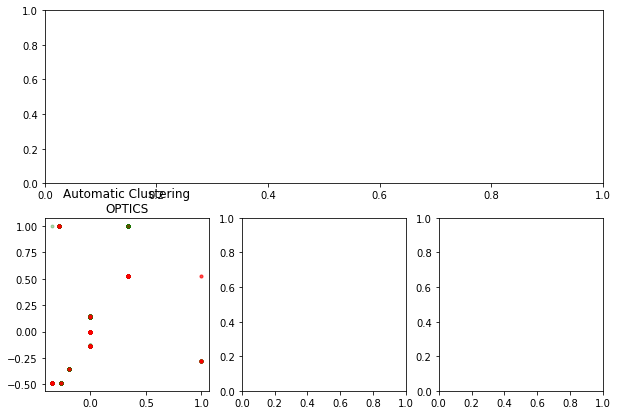

In [118]:
plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# OPTICS
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = X_train[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X_train[clust.labels_ == -1, 0], X_train[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')